In [1]:
import os
import sys
import torch
import subprocess
need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
    version_str="".join([
        f"py3{sys.version_info.minor}_cu",
        torch.version.cuda.replace(".",""),
        f"_pyt{pyt_version_str}"
    ])
    !pip install iopath
    if sys.platform.startswith("linux"):
        print("Trying to install wheel for PyTorch3D")
        !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
        pip_list = !pip freeze
        need_pytorch3d = not any(i.startswith("pytorch3d==") for  i in pip_list)
    if need_pytorch3d:
        print(f"failed to find/install wheel for {version_str}")
if need_pytorch3d:
    print("Installing PyTorch3D from source")
    !pip install ninja
    !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

In [2]:
# Import necessary libraries
import numpy as np
from tqdm.notebook import tqdm
import imageio
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from skimage import img_as_ubyte
from IPython.display import clear_output

# io utils
from pytorch3d.io import load_obj

# datastructures
from pytorch3d.structures import Meshes

# 3D transformations functions
from pytorch3d.transforms import Rotate, Translate

# rendering components
from pytorch3d.renderer import (
    FoVPerspectiveCameras, look_at_view_transform, look_at_rotation,
    RasterizationSettings, MeshRenderer, MeshRasterizer, BlendParams,
    SoftSilhouetteShader, HardPhongShader, PointLights, TexturesVertex,
)

In [3]:
# Set the cuda device
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
    print("GPU")
else:
    device = torch.device("cpu")
    print("CPU")

GPU


In [4]:
# Load the mesh (clipMesh.obj)
verts, faces_idx, _ = load_obj("/home/exouser/pose_estim/clipestimator/data/mesh/clipMesh.obj")
faces = faces_idx.verts_idx

/home/exouser/anaconda3/envs/blvenv/lib/python3.9/site-packages/pytorch3d/io/obj_io.py:550: UserWarning: Mtl file does not exist: /home/exouser/pose_estim/clipestimator/data/mesh/Item.mtl
  warnings.warn(f"Mtl file does not exist: {f}")


In [5]:
# Initialize each vertex to be white in color.
verts_rgb = torch.ones_like(verts)[None]  # (1, V, 3)
textures = TexturesVertex(verts_features=verts_rgb.to(device))

# Create a Meshes object for the clipMesh.
clip_mesh = Meshes(
    verts=[verts.to(device)],
    faces=[faces.to(device)],
    textures=textures
)

# Initialize a perspective camera.
cameras = FoVPerspectiveCameras(device=device)

# Set blend parameters for silhouette rendering
blend_params = BlendParams(sigma=1e-4, gamma=1e-4)

# Rasterization settings for silhouette rendering
raster_settings_silhouette = RasterizationSettings(
    image_size=256,  # Match the reference image size
    blur_radius=np.log(1. / 1e-4 - 1.) * blend_params.sigma,
    faces_per_pixel=50,
)

# Silhouette renderer
silhouette_renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras,
        raster_settings=raster_settings_silhouette
    ),
    shader=SoftSilhouetteShader(blend_params=blend_params)
)

# Rasterization settings for Phong rendering (for visualization)
raster_settings_phong = RasterizationSettings(
    image_size=256,  # Match the reference image size
    blur_radius=0.0,
    faces_per_pixel=1,
)

# Lighting settings for Phong rendering
lights = PointLights(device=device, location=((2.0, 2.0, -2.0),))

# Phong renderer
phong_renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras,
        raster_settings=raster_settings_phong
    ),
    shader=HardPhongShader(device=device, cameras=cameras, lights=lights)
)


In [6]:
from pytorch3d.renderer import (
    FoVPerspectiveCameras, look_at_rotation,
    RasterizationSettings, MeshRenderer, MeshRasterizer,
    SoftSilhouetteShader, BlendParams
)
import torch.nn.functional as F

# Camera and blend parameters
cameras = FoVPerspectiveCameras(device=device)
blend_params = BlendParams(sigma=1e-4, gamma=1e-4)

# Rasterization settings for silhouette rendering (binary output)
raster_settings_binary = RasterizationSettings(
    image_size=256,  # Render images at 256x256 resolution
    blur_radius=np.log(1. / 1e-4 - 1.) * blend_params.sigma,
    faces_per_pixel=25,
)

# Binary silhouette renderer
binary_renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras,
        raster_settings=raster_settings_binary
    ),
    shader=SoftSilhouetteShader(blend_params=blend_params)
)

In [7]:
# Select the viewpoint using spherical angles
distance = 25   # distance from camera to the object
elevation = 20.0   # angle of elevation in degrees
azimuth = 40.0  # No rotation so the camera is positioned on the +Z axis.

# Get the position of the camera based on the spherical angles
R, T = look_at_view_transform(distance, elevation, azimuth, device=device)
print(R, T)

tensor([[[-0.7660, -0.2198, -0.6040],
         [ 0.0000,  0.9397, -0.3420],
         [ 0.6428, -0.2620, -0.7198]]], device='cuda:0') tensor([[-0.0000e+00, 9.5367e-07, 2.5000e+01]], device='cuda:0')


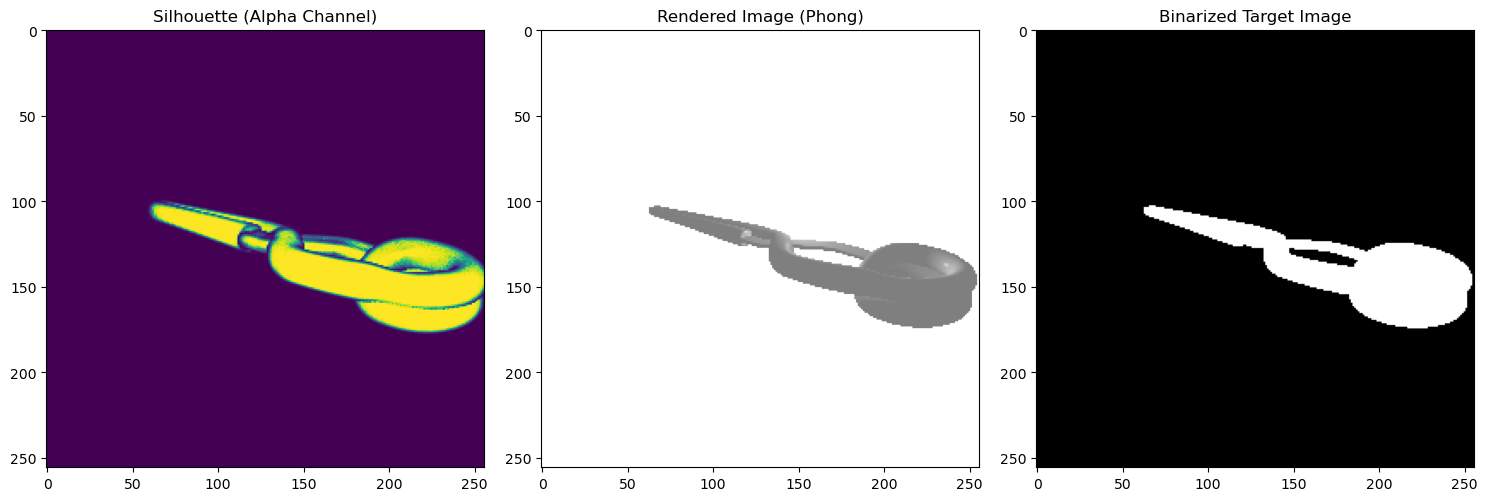

In [8]:
# Render the mesh providing the values of R and T.
silhouette = silhouette_renderer(meshes_world=clip_mesh, R=R, T=T)
image_ref = phong_renderer(meshes_world=clip_mesh, R=R, T=T)

silhouette = silhouette.cpu().numpy()
image_ref = image_ref.cpu().numpy()

# Binarize the image_ref
binarization_threshold = 0.95  # Adjust this threshold as needed
image_ref_gray = np.mean(image_ref.squeeze()[..., :3], axis=-1)  # Convert to grayscale
image_ref_binary = (image_ref_gray > binarization_threshold).astype(np.uint8)

# Invert the binary target image to match the renderer's convention
image_ref_binary = 1 - image_ref_binary  # Flip 0s and 1s

# Plot the images
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(silhouette.squeeze()[..., 3])  # Alpha channel of the silhouette
plt.title("Silhouette (Alpha Channel)")
plt.grid(False)

plt.subplot(1, 3, 2)
plt.imshow(image_ref.squeeze())
plt.title("Rendered Image (Phong)")
plt.grid(False)

plt.subplot(1, 3, 3)
plt.imshow(image_ref_binary, cmap='gray')  # Binarized and inverted image
plt.title("Binarized Target Image")
plt.grid(False)

plt.tight_layout()
plt.show()


In [14]:
class BinaryModel(nn.Module):
    def __init__(self, meshes, renderer, image_ref):
        super().__init__()
        self.meshes = meshes
        self.device = meshes.device
        self.renderer = renderer

        # Ensure the reference image is binary and compatible
        image_ref = torch.from_numpy(image_ref).to(meshes.device).float()

        # Add batch and channel dimensions
        self.image_ref = image_ref.unsqueeze(0).unsqueeze(0)  # Shape: (1, 1, H, W)

        # Create an optimizable parameter for the x, y, z position of the camera
        self.camera_position = nn.Parameter(
            torch.from_numpy(np.array([15.0, 15.0, +15.0], dtype=np.float32)).to(meshes.device)
        )

    def forward(self):
        # Render the binary image using the updated camera position
        R = look_at_rotation(self.camera_position[None, :], device=self.device)
        T = -torch.bmm(R.transpose(1, 2), self.camera_position[None, :, None])[:, :, 0]

        image = silhouette_renderer(meshes_world=self.meshes.clone(), R=R, T=T)
        image_phong = phong_renderer(meshes_world=self.meshes.clone(), R=R, T=T)
        print(R, T)


        # Extract the alpha channel of the rendered image
        image_alpha_s = image[..., 3]  # Shape: (1, H, W)

        # Smooth approximation for binarization
        binarization_threshold = 0.95
        image_binary_s = torch.sigmoid((image_alpha_s - binarization_threshold) * 5)  # Shape: (1, H, W)

        # Add a channel dimension to match the reference image
        image_binary_s = image_binary_s.unsqueeze(1)  # Shape: (1, 1, H, W)

        # Extract the alpha channel of the rendered image
        image_alpha = image_phong[..., 3]  # Shape: (1, H, W)

        # Smooth approximation for binarization
        binarization_threshold = 0.95
        image_binary = torch.sigmoid((image_alpha - binarization_threshold) * 5)  # Shape: (1, H, W)

        # Add a channel dimension to match the reference image
        image_binary = image_binary.unsqueeze(1)  # Shape: (1, 1, H, W)

        # Compute binary cross-entropy loss
        loss = F.binary_cross_entropy(image_binary_s, self.image_ref)

        # MSE? RMSE?

        return loss, image_binary_s, image_binary

In [15]:
# Initialize the binary reference image
image_ref_binary = (image_ref_binary > 0.95).astype(np.float32)  # Ensure binary format

# Initialize the model
model = BinaryModel(meshes=clip_mesh, renderer=silhouette_renderer, image_ref=image_ref_binary).to(device)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.03)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.05, momentum=0.95)


tensor([[[-0.7071, -0.4082, -0.5774],
         [ 0.0000,  0.8165, -0.5774],
         [ 0.7071, -0.4082, -0.5774]]], device='cuda:0',
       grad_fn=<TransposeBackward0>) tensor([[-0.0000, -0.0000, 25.9808]], device='cuda:0', grad_fn=<NegBackward0>)
Iteration 0, Loss: 0.2536906599998474
tensor([[[-0.7071, -0.4072, -0.5781],
         [ 0.0000,  0.8176, -0.5758],
         [ 0.7071, -0.4072, -0.5781]]], device='cuda:0',
       grad_fn=<TransposeBackward0>) tensor([[-0.0000, -0.0000, 25.9981]], device='cuda:0', grad_fn=<NegBackward0>)
tensor([[[-0.7071, -0.4061, -0.5789],
         [ 0.0000,  0.8187, -0.5743],
         [ 0.7071, -0.4061, -0.5789]]], device='cuda:0',
       grad_fn=<TransposeBackward0>) tensor([[-0.0000, -0.0000, 26.0156]], device='cuda:0', grad_fn=<NegBackward0>)
tensor([[[-0.7071, -0.4050, -0.5796],
         [ 0.0000,  0.8197, -0.5727],
         [ 0.7071, -0.4050, -0.5796]]], device='cuda:0',
       grad_fn=<TransposeBackward0>) tensor([[-0.0000e+00, 9.5367e-07, 2.6033e+01]

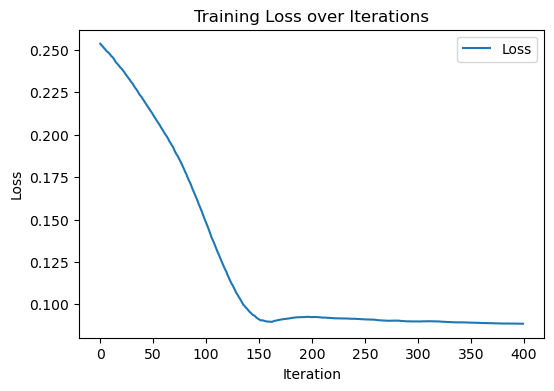

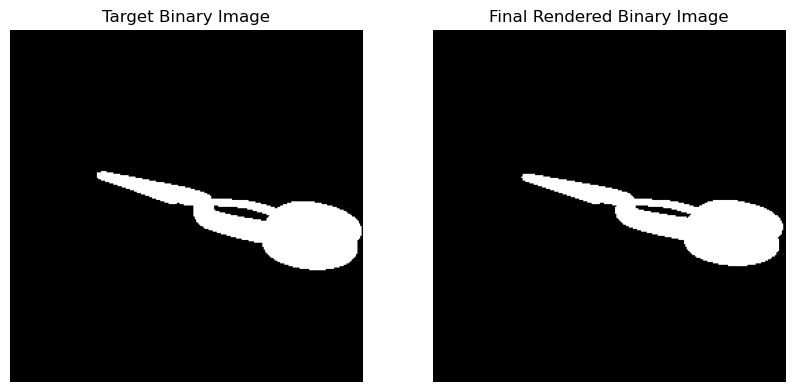

In [16]:
# Training loop
num_iterations = 400
loss_values = []

for i in range(num_iterations):
    optimizer.zero_grad()
    loss, rendered_image_binary, phong = model()  # Forward pass

    # Regularize camera position
    #camera_reg = 0.01 * torch.sum(model.camera_position ** 2)
    #loss += camera_reg

    # Ensure numerical stability in loss computation
    '''eps = 1e-7
    rendered_image_binary = torch.clamp(rendered_image_binary, eps, 1 - eps)
    bce_loss = -torch.mean(
        model.image_ref * torch.log(rendered_image_binary + eps) +
        (1 - model.image_ref) * torch.log(1 - rendered_image_binary + eps)
    )
    loss += bce_loss'''

    # Backward pass
    loss.backward()

    # Gradient clipping
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()

    # Store loss for plotting
    loss_values.append(loss.item())

    # Print progress every 50 iterations
    if i % 50 == 0 or i == num_iterations - 1:
        print(f"Iteration {i}, Loss: {loss.item()}")

# Plot the loss curve
plt.figure(figsize=(6, 4))
plt.plot(loss_values, label="Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Training Loss over Iterations")
plt.legend()
plt.show()

# Display final comparison
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(model.image_ref.detach().cpu().squeeze(), cmap="gray")
plt.title("Target Binary Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(phong.detach().cpu().squeeze(), cmap="gray")
plt.title("Final Rendered Binary Image")
plt.axis("off")
plt.show()


In [42]:
# Function to generate a target binary image
def generate_target_image(distance, elevation, azimuth):
    # Ensure the camera is sufficiently far from the mesh
    verts_world = clip_mesh.verts_packed()  # Get the mesh vertices
    bbox_min = verts_world.min(dim=0).values  # Bounding box minimum
    bbox_max = verts_world.max(dim=0).values  # Bounding box maximum
    bbox_diagonal = torch.norm(bbox_max - bbox_min)  # Diagonal length of the bounding box
    min_distance = bbox_diagonal.item() * 1  # Set minimum distance as 1x diagonal length

    if distance < min_distance:
        print(f"Warning: Adjusting camera distance from {distance} to minimum {min_distance}")
        distance = min_distance

    # Compute the camera transformation
    R, T = look_at_view_transform(dist=distance, elev=elevation, azim=azimuth, device=device)

    # Render the silhouette image
    silhouette = silhouette_renderer(meshes_world=clip_mesh, R=R, T=T)
    image_ref = phong_renderer(meshes_world=clip_mesh, R=R, T=T)

    # Convert silhouette to numpy
    silhouette = silhouette.cpu().numpy()
    image_ref = image_ref.cpu().numpy()

    # Binarize the rendered image (Phong renderer)
    binarization_threshold = 0.95  # Adjust as needed
    image_ref_gray = np.mean(image_ref.squeeze()[..., :3], axis=-1)  # Convert to grayscale
    target_image = (image_ref_gray > binarization_threshold).astype(np.uint8)  # Binary image

    # Invert the binary target image to match the renderer's convention
    target_image = 1 - target_image  # Flip 0s and 1s

    return target_image



# Generate 10 target images with different camera parameters
target_images = [
    generate_target_image(distance=5.0, elevation=20 + i * 10, azimuth=45 + i * 10)
    for i in range(10)
]

# Function to train the model and collect results
def run_trials(target_images, num_iterations=300):
    results = []
    
    for i, target_image in enumerate(target_images):
        print(f"Running trial {i + 1}/{len(target_images)}...")

        # Fully reinitialize the model and optimizer for each trial
        model = BinaryModel(meshes=clip_mesh, renderer=silhouette_renderer, image_ref=target_image).to(device)
        optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

        # Train the model
        loss_values = []
        for _ in range(num_iterations):
            optimizer.zero_grad()
            loss, rendered_image_binary = model()  # Forward pass
            loss.backward()  # Backward pass
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
            optimizer.step()  # Update parameters
            loss_values.append(loss.item())  # Store the loss
        
        # Store results for this trial
        results.append({
            "target_image": target_image,
            "rendered_image": rendered_image_binary.detach().cpu().squeeze().numpy(),
            "loss_values": loss_values,
        })
    
    return results



# Run the trials
results = run_trials(target_images)

# Plot the results
fig, axes = plt.subplots(len(results), 3, figsize=(15, 5 * len(results)))

for i, result in enumerate(results):
    target_ax, rendered_ax, loss_ax = axes[i]

    # Plot target binary image
    target_ax.imshow(result["target_image"], cmap="gray")
    target_ax.set_title(f"Trial {i + 1}: Target Binary Image")
    target_ax.axis("off")
    
    # Plot final rendered binary image
    rendered_ax.imshow(result["rendered_image"], cmap="gray")
    rendered_ax.set_title(f"Trial {i + 1}: Final Rendered Binary Image")
    rendered_ax.axis("off")
    
    # Plot training loss
    loss_ax.plot(result["loss_values"])
    loss_ax.set_title(f"Trial {i + 1}: Training Loss")
    loss_ax.set_xlabel("Iteration")
    loss_ax.set_ylabel("Loss")

plt.tight_layout()
plt.show()

Running trial 1/10...
Running trial 2/10...
Running trial 3/10...
Running trial 4/10...


KeyboardInterrupt: 